In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

%matplotlib inline

save_figures = False
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Dispersive_Simulations"

sys.path.append("../utils")


In [99]:
simulation_steps = 2501

# Setup Qubit, Resonator and Coupling
n_cutoff    = 15
EJ          = 15     * 2 * np.pi # h GHz
EC          = EJ / 25

resonator_states        = 20
resonator_frequency     = 6.02 * 2 * np.pi    

coupling_strength       = 0.250 * 2 * np.pi


# Setup drive
drive_amplitude        = 0.020
driving_time           = (0, 2500)
drive_function         = lambda t, args: drive_amplitude * np.cos(args["driving_frequency"] * t)


# Loss parameters:
# Setup the qubit decay
rate_qubit_decay  = 1 / 10000
rate_qubit_excite = 0 # 1 / 1000
rate_reso = 1 / 75


# driving_frequencies_to_scan = 2 * np.pi * np.linspace(*scan_range, resolution)

# Define Qubit object
import components as comp
qubit = comp.Transmon(
    EC = EC,
    EJ = EJ,
    basis = "charge",
    n_cutoff = n_cutoff
)
# Define resonator operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()

In [100]:
qubit_states = 3

# Get Qubit operators for the two level qubit
H_qubit, jump_matrix = qubit.lowest_k_eigenstates(k = qubit_states)

In [101]:
# Calculate all types of constants, which is useful for further analysis:
omega_01 = H_qubit.diag()[1] - H_qubit.diag()[0]
omega_02 = H_qubit.diag()[2] - H_qubit.diag()[0]
omega_12 = H_qubit.diag()[2] - H_qubit.diag()[1]

# Calculate the dispersive shifts
# Multi qubit shifts
g_squared_matrix = coupling_strength ** 2 * abs(jump_matrix.full()) ** 2
omega_ij_matrix = np.expand_dims(H_qubit.diag(), 1) - np.expand_dims(H_qubit.diag(), 0)
omega_r = resonator_frequency

# The Chi-matrix
chi_matrix = g_squared_matrix * (1 / (omega_ij_matrix - omega_r) + 1 / (omega_ij_matrix + omega_r)) 

# The dis
dispersive_shifts = chi_matrix.sum(axis = 1) / 2 / np.pi


# Omega resonator for qubits
omega_resonator_qubit = resonator_frequency + dispersive_shifts



# Information to print:
printing_dict = {
    "omega_01" : f"{omega_01 / 2 / np.pi:.3f} GHz",
    "omega_12" : f"{omega_12 / 2 / np.pi:.3f} GHz",
    "omega_02" : f"{omega_02 / 2 / np.pi:.3f} GHz",
    "omega_r"  : f"{resonator_frequency / 2 / np.pi:.3f} GHz",
    "omega_r_tilde": f"{np.mean(omega_resonator_qubit[:2]) / 2 / np.pi:.3f} GHz",
    "coupling_strength": f"{coupling_strength / 2 / np.pi:.3f} GHz",
    "dispersive_shift": f"{(dispersive_shifts[0] - dispersive_shifts[1]) * 1000 / 2 / 2 / np.pi:.3f} MHz",
    "drive_amplitude": f"{drive_amplitude * 1000:.3f} MHz",
    "driving_time": f"{driving_time[1]} ns",
    "rate_qubit_decay": f"{rate_qubit_decay * 1000:.3f} MHz",
    "rate_qubit_excite": f"{rate_qubit_excite * 1000:.3f} MHz",
    "rate_reso": f"{rate_reso * 1000:.3f} MHz",
}

printing_dict_symbolic = {
    r"\omega_{01}" : f"{omega_01 / 2 / np.pi:.3f} GHz",
    r"\omega_{12}" : f"{omega_12 / 2 / np.pi:.3f} GHz",
    r"\omega_{02}" : f"{omega_02 / 2 / np.pi:.3f} GHz",
    r"\omega_r"  : f"{resonator_frequency / 2 / np.pi:.3f} GHz",
    r"\tilde{\omega_r}": f"{np.mean(omega_resonator_qubit[:2]) / 2 / np.pi:.3f} GHz",
    r"g" : f"{coupling_strength / 2 / np.pi:.3f} GHz",
    r"\chi" : f"{(dispersive_shifts[0] - dispersive_shifts[1]) * 1000 / 2 / 2 / np.pi:.3f} MHz",
    r"A" : f"{drive_amplitude * 1000:.3f} MHz",
    r"T" : f"{driving_time[1]} ns",
    r"\Gamma_q" : f"{rate_qubit_decay * 1000:.3f} MHz",
    r"\Gamma_e" : f"{rate_qubit_excite * 1000:.3f} MHz",
    r"\Gamma_r" : f"{rate_reso * 1000:.3f} MHz",
}

variable_dict = {
    "omega_01" : omega_01,
    "omega_12" : omega_12,
    "omega_02" : omega_02,
    "omega_r"  : resonator_frequency,
    "omega_r_tilde": np.mean(omega_resonator_qubit[:2]),
    "coupling_strength": coupling_strength,
    "dispersive_shift": (dispersive_shifts[0] - dispersive_shifts[1]),
}

for key, value in printing_dict.items():
    print(f"{key} \t= {value}")

omega_01 	= 7.834 GHz
omega_12 	= 7.050 GHz
omega_02 	= 14.884 GHz
omega_r 	= 6.020 GHz
omega_r_tilde 	= 6.012 GHz
coupling_strength 	= 0.250 GHz
dispersive_shift 	= 2.600 MHz
drive_amplitude 	= 20.000 MHz
driving_time 	= 2500 ns
rate_qubit_decay 	= 0.100 MHz
rate_qubit_excite 	= 0.000 MHz
rate_reso 	= 13.333 MHz


For now, we will just consider the dispersive approximation where the Hamiltonian is not time dependent in this basis:

### Simulation for the Dispersive Limit Hamiltonian
Non interacting:  

$H_{eff} = (\omega_r - \omega_d  + \sum_k \chi_k \ket{k}\ket{k} ) a^\dagger a$

Driving

$H_{d, eff} = \epsilon (a^\dagger + a)$

In [102]:
from qutip import tensor, basis, ket2dm
from tqdm import tqdm

# We can now define the Hamiltonian:
def get_Hamiltonian(drive_frequency):
    H_res   = (omega_r - drive_frequency) * tensor(qutip.qeye(qubit_states), a_dag * a)

    H_disp  = tensor(qutip.Qobj(np.diag(dispersive_shifts)), a_dag * a)

    H_drive = drive_amplitude * tensor(qutip.qeye(qubit_states), a_dag + a)

    return H_res + H_disp + H_drive


Now we setup the different parameters to watch in the simulation:

In [103]:
# We want expectation values of the following operators throughout the simulation:
I = a + a_dag
Q = 1j * (a_dag - a)
n = a_dag * a

exp_value_operators = [I, Q, n]
from qutip import ptrace, expect
# exp_value_operators = [lambda t, state: expect(op, ptrace(state, 1)) for op in exp_value_operators]
def exp_values(t, state):
    reso_state = ptrace(state, 1)
    exp_vals   = [expect(op, reso_state) for op in exp_value_operators]
    return exp_vals

# We choose to drive it resonant to the qubit_0 frequency
drive_frequency = omega_resonator_qubit[0] / 2 + omega_resonator_qubit[1]  / 2 # variable_dict["omega_r_tilde"]
hamiltonian = get_Hamiltonian(drive_frequency)



## Setup collapse operators and decay rates

First we just setup the qubit decay. $\ket{1} \to \ket{0}$. This happens with a rate $\Gamma_1 = \frac{1}{T_1}$.

The corresponding Lindblad operator is $\ket{0}\bra{1}$. And of course nothing happens on the resonator:

In [104]:
qubit_decay_matrix = np.zeros((qubit_states, qubit_states))
qubit_decay_matrix[0, 1] = 1

qubit_decay = np.sqrt(rate_qubit_decay) * tensor(qutip.Qobj(qubit_decay_matrix), qutip.qeye(resonator_states))
qubit_excitation = np.sqrt(rate_qubit_excite) * tensor(qutip.Qobj(qubit_decay_matrix.T), qutip.qeye(resonator_states))


# Setup the resonator decay

reso_decay = np.sqrt(rate_reso) * tensor(qutip.qeye(qubit_states), a)


decays = [qubit_decay, qubit_excitation, reso_decay]

## Run the Simulation

In [105]:
# And simply start in the intial state
initial_qubit = basis(qubit_states, 0)
initial_resonator = basis(resonator_states, 0)
initial_state = ket2dm(tensor(initial_qubit, initial_resonator))


tlist = np.linspace(*driving_time, simulation_steps)

# We can now simulate the system
from qutip import mesolve, Options
result_0 = mesolve(
    hamiltonian,
    initial_state,
    tlist = tlist,
    c_ops = decays,
    e_ops = exp_values,
    options = Options(store_states = True),
    progress_bar = True
)

exp_values_from_simulation_0 = np.array(result_0.expect)

# Do the same for first excited state
initial_qubit = basis(qubit_states, 1)
initial_resonator = basis(resonator_states, 0)
initial_state = ket2dm(tensor(initial_qubit, initial_resonator))

result_1 = mesolve(
    hamiltonian,
    initial_state,
    tlist = tlist,
    c_ops = decays,
    e_ops = exp_values,
    options = Options(store_states = True),
    progress_bar = True
)

exp_values_from_simulation_1 = np.array(result_1.expect)

10.0%. Run time:   0.21s. Est. time left: 00:00:00:01
20.0%. Run time:   0.46s. Est. time left: 00:00:00:01
30.0%. Run time:   0.69s. Est. time left: 00:00:00:01
40.0%. Run time:   1.02s. Est. time left: 00:00:00:01
50.0%. Run time:   1.26s. Est. time left: 00:00:00:01
60.0%. Run time:   1.47s. Est. time left: 00:00:00:00
70.0%. Run time:   1.69s. Est. time left: 00:00:00:00
80.0%. Run time:   1.90s. Est. time left: 00:00:00:00
90.0%. Run time:   2.16s. Est. time left: 00:00:00:00
Total run time:   2.48s
10.0%. Run time:   0.27s. Est. time left: 00:00:00:02
20.0%. Run time:   0.51s. Est. time left: 00:00:00:02
30.0%. Run time:   0.74s. Est. time left: 00:00:00:01
40.0%. Run time:   0.97s. Est. time left: 00:00:00:01
50.0%. Run time:   1.19s. Est. time left: 00:00:00:01
60.0%. Run time:   1.49s. Est. time left: 00:00:00:00
70.0%. Run time:   1.69s. Est. time left: 00:00:00:00
80.0%. Run time:   1.89s. Est. time left: 00:00:00:00
90.0%. Run time:   2.10s. Est. time left: 00:00:00:00
Tota

## Plotting the Results

In [106]:
from matplotlib.colors import LinearSegmentedColormap
cmap_0 = LinearSegmentedColormap.from_list("mycmap", ["white", "C0"])
cmap_1 = LinearSegmentedColormap.from_list("mycmap", ["white", "C1"])



In [107]:
xvec = yvec = np.linspace(-5, 5, 100)

from qutip import QFunc
qfunc = QFunc(xvec, yvec)

qvals = qfunc(result_1.states[-1].ptrace(1))

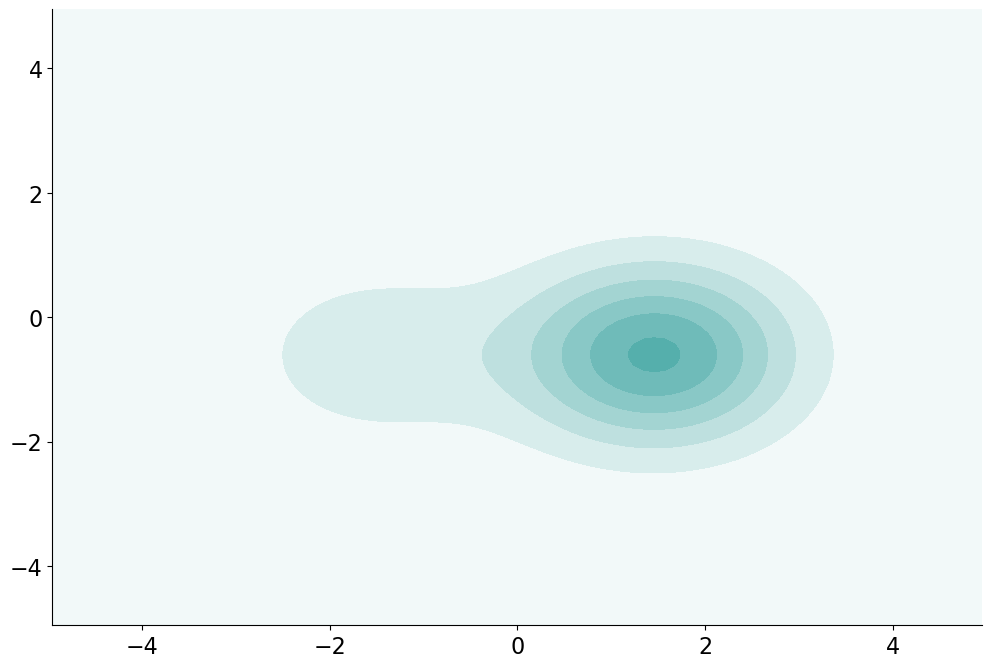

In [108]:
plt.contourf(qvals, extent=[-5, 5, -5, 5], origin="lower", cmap = cmap_1)

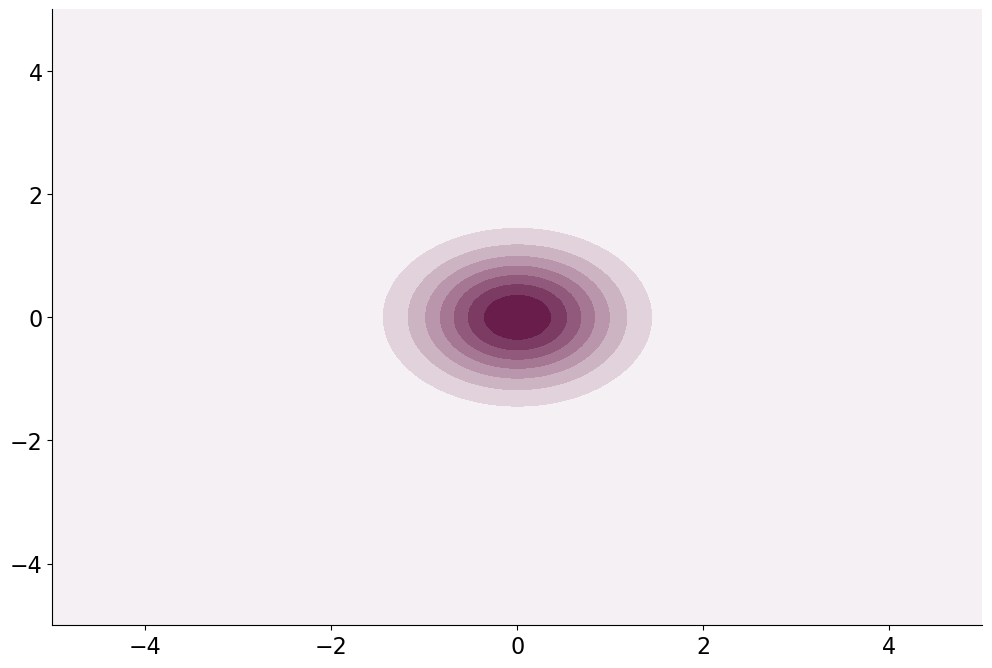

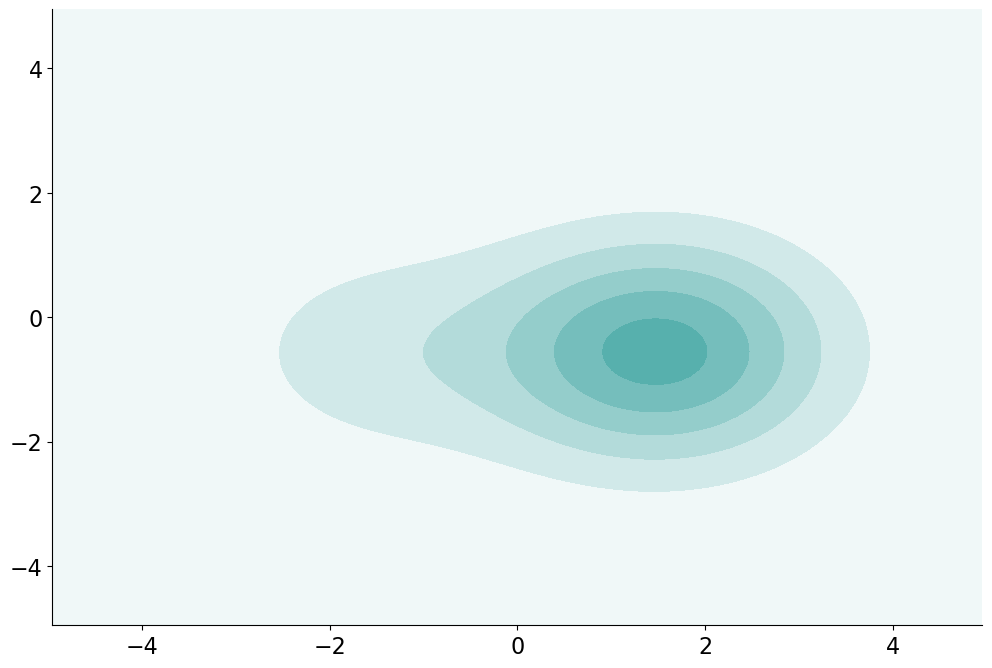

In [130]:
from scipy.stats import multivariate_normal
X, Y = np.meshgrid(xvec, yvec)
gauss = multivariate_normal(mean = [0, 0], cov = .5 * np.eye(2)).pdf(np.array([X, Y]).T)

plt.contourf(X, Y, gauss, cmap = cmap_0)

plt.figure()
from scipy.signal import convolve
plt.contourf(convolve(qvals, gauss, mode = "same"), extent=[-5, 5, -5, 5], origin="lower", cmap = cmap_1)

In [121]:
from scipy.signal import fftconvolve
plt.contourf(fftconvolve(qvals, gauss, mode = "same"), extent=[-5, 5, -5, 5], origin="lower", cmap = cmap_1)

In [109]:

printing_dict_symbolic[r"\epsilon"] = f"{drive_amplitude * 1000:.3f} MHz"
printing_dict_symbolic[r"\omega_{drive}"] = f"{drive_frequency / 2 / np.pi:.3f} GHz"

written_out = [f"${key} \t= {value}$" for key, value in printing_dict_symbolic.items()]
text_to_print = "\n".join(written_out)

def segment_sum(data, segment_ids, reso = 100):
    data = np.asarray(data)
    s = np.zeros((reso), dtype=data.dtype)
    np.add.at(s, segment_ids, data)
    return s


In [110]:
from ipywidgets import embed



In [111]:
from scipy.stats import multivariate_normal

X, Y = np.meshgrid(xvec, yvec)

multivariate_normal(mean = [0, 0], cov = np.diag([1, 1])).pdf(np.array([X, Y]).T)

array([[2.21033492e-12, 3.64404028e-12, 5.94671507e-12, ...,
        5.94671507e-12, 3.64404028e-12, 2.21033492e-12],
       [3.64404028e-12, 6.00770024e-12, 9.80397547e-12, ...,
        9.80397547e-12, 6.00770024e-12, 3.64404028e-12],
       [5.94671507e-12, 9.80397547e-12, 1.59991230e-11, ...,
        1.59991230e-11, 9.80397547e-12, 5.94671507e-12],
       ...,
       [5.94671507e-12, 9.80397547e-12, 1.59991230e-11, ...,
        1.59991230e-11, 9.80397547e-12, 5.94671507e-12],
       [3.64404028e-12, 6.00770024e-12, 9.80397547e-12, ...,
        9.80397547e-12, 6.00770024e-12, 3.64404028e-12],
       [2.21033492e-12, 3.64404028e-12, 5.94671507e-12, ...,
        5.94671507e-12, 3.64404028e-12, 2.21033492e-12]])

In [112]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from scipy.stats import multivariate_normal



def inspect_results(time, gaussian_width = 0.1):
    time_idx = int(time / (driving_time[1] - driving_time[0]) * simulation_steps)

    fig = plt.figure(figsize = (12, 12))
    gs  = GridSpec(3, 3, figure = fig)

    ax0 = fig.add_subplot(gs[0, :2])
    ax0.plot(result_0.times, exp_values_from_simulation_0[:, 2])
    ax0.plot(result_1.times, exp_values_from_simulation_1[:, 2])
    ax0.set(
        xlabel = "Time [ns]",
        ylabel = "Occupation number",
        title = "Occupation of the Resonator"
    )
    ax0.vlines(time, *ax0.get_ylim(), color = "gray", ls = "--")

    ax1 = fig.add_subplot(gs[0, 2])
    ax1.plot(exp_values_from_simulation_0[:, 0], exp_values_from_simulation_0[:, 1], ls = "--", alpha = 0.5, label = "I(t), Q(t)" )
    ax1.plot(exp_values_from_simulation_1[:, 0], exp_values_from_simulation_1[:, 1], ls = "--", alpha = 0.5)

    mark_every = 50 # ns
    mark_every_idx = int(mark_every / (driving_time[1] - driving_time[0]) * simulation_steps)

    ax1.scatter(exp_values_from_simulation_0[time_idx, 0], exp_values_from_simulation_0[time_idx, 1], marker = "x", color = "gray", s = 200)
    ax1.scatter(exp_values_from_simulation_1[time_idx, 0], exp_values_from_simulation_1[time_idx, 1], marker = "x", color = "gray", s = 200)

    ax1.set(
        xlabel = "<I>",
        ylabel = "<Q>",
        title = "I-Q plot of resonator",
        xlim = (xvec[0], xvec[-1]),
        ylim = (yvec[0], yvec[-1])

    )

    # gauss_conv = multivariate_normal.pdf(xvec, y_vec)

    ax2 = fig.add_subplot(gs[1:, :2])

    ax2.contour(qfunc(ptrace(result_0.states[time_idx], 1)), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], origin = "lower", cmap = cmap_0, alpha = 0.7)
    ax2.contour(qfunc(ptrace(result_1.states[time_idx], 1)), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], origin = "lower", cmap = cmap_1, alpha = 0.7)
    ax2.set(
        xlabel = r"$Re(\alpha)$",
        ylabel = r"$Im(\alpha)$",
        title = "Q-function of Resonator"
    )

    ax3 = fig.add_subplot(gs[1:, 2])

    X, Y = np.meshgrid(xvec, yvec)
    q_0, q_1 = qfunc(ptrace(result_0.states[time_idx], 1)), qfunc(ptrace(result_1.states[time_idx], 1))
    
    means_0 = np.array((np.sum(X * q_0) / np.sum(q_0), np.sum(Y * q_0) / np.sum(q_0)))
    means_1 = np.array((np.sum(X * q_1) / np.sum(q_1), np.sum(Y * q_1) / np.sum(q_1)))

    vects   = means_0 - means_1
    if vects[0] != 0 and vects[1] != 0:
        vects  /= np.linalg.norm(vects)

        coordinates_on_primary_axis = vects[0] * X + vects[1] * Y
        
        x_primes = np.linspace(coordinates_on_primary_axis.min(), coordinates_on_primary_axis.max(), 100)
        binwidth = x_primes[1] - x_primes[0]

        idxs = coordinates_on_primary_axis.flatten() / binwidth
        idxs = (idxs - idxs.min()).astype(int)

        density_on_primary_axis_0 = segment_sum(q_0.flatten(), idxs) / binwidth
        density_on_primary_axis_1 = segment_sum(q_1.flatten(), idxs) / binwidth

        ax3.plot(density_on_primary_axis_0, x_primes)
        ax3.plot(density_on_primary_axis_1, x_primes)

        ax3.set(
            xlabel = "Projected Q-func",
            ylabel = "Coordinate on primary axis",
            title  = "Q-Function Projection"
        )

    
        line_xs = np.linspace(*ax2.get_xlim(), 100)
        line_ys = (line_xs -  means_0[0]) * vects[1] / vects[0] +  means_0[1]

        ax2.plot(line_xs, line_ys, color = "gray", ls = "-.")
        ax2.scatter(means_0[0], means_0[1], marker = "x", color = "C0", s = 200)
        ax2.scatter(means_1[0], means_1[1], marker = "x", color = "C1", s = 200)

    # fig.text(0.75, 0.4, text_to_print)

    legend_lines = [Line2D([0], [0], color = "C0", lw = 4), Line2D([0], [0], color = "C1", lw = 4)]
    ax0.legend(legend_lines, [r"$|0\rangle$", r"$|1\rangle$"], loc = "upper left", ncol = 1)#, bbox_to_anchor = (0.5, 0.05))

    fig.tight_layout()



from ipywidgets import interact
interact(inspect_results, time = (0, driving_time[1] - 1, 10))

interactive(children=(IntSlider(value=1240, description='time', max=2499, step=10), FloatSlider(value=0.1, des…

<function __main__.inspect_results(time, gaussian_width=0.1)>

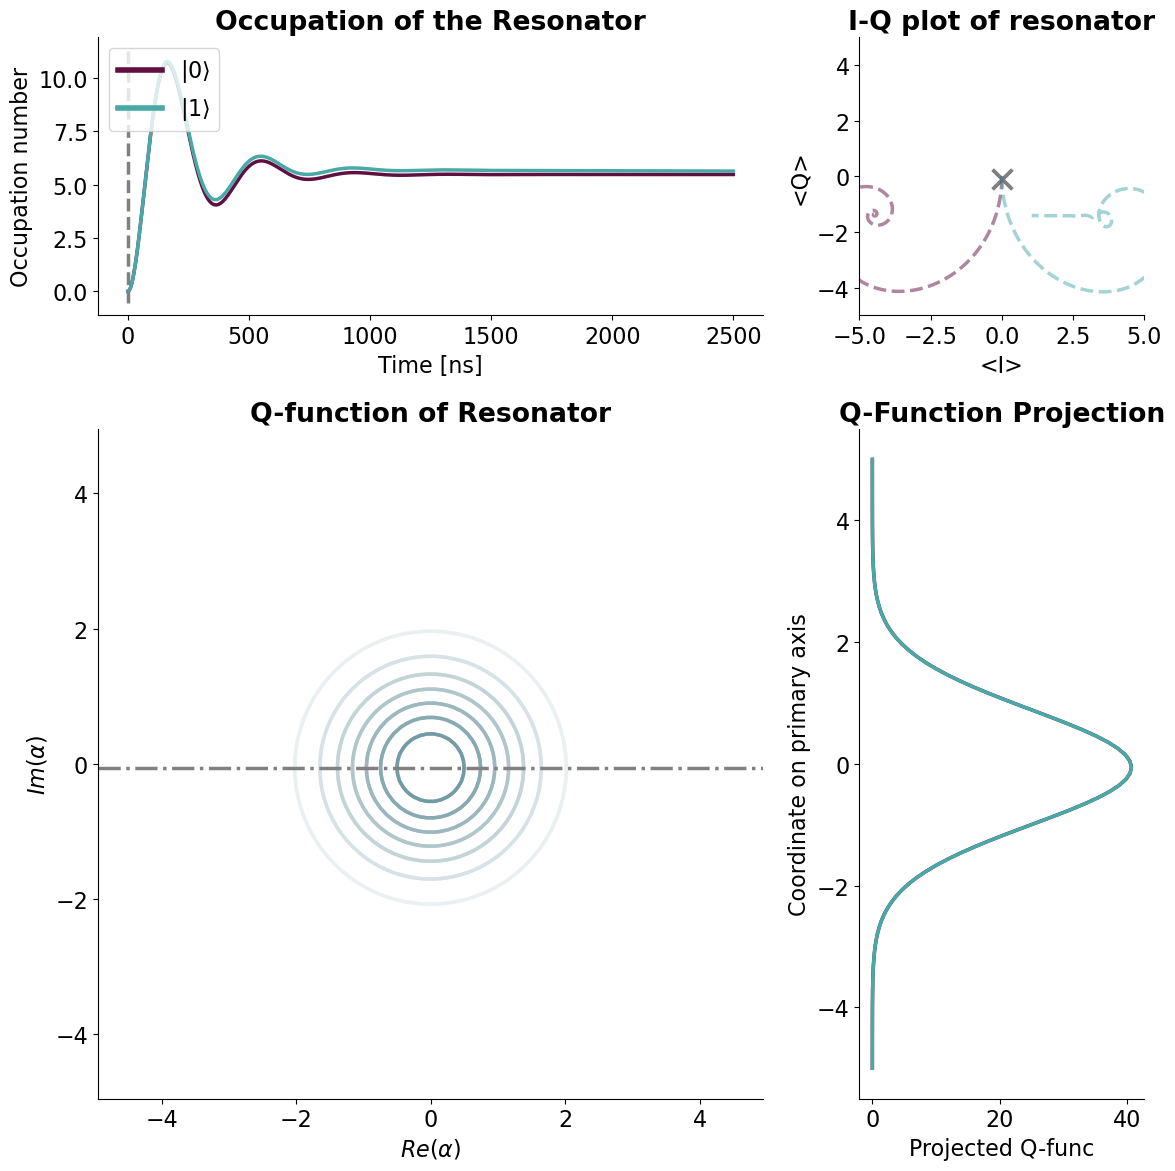

In [70]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

time_idx = int(1 / (driving_time[1] - driving_time[0]) * simulation_steps)

fig = plt.figure(figsize = (12, 12))
gs  = GridSpec(3, 3, figure = fig)

ax0 = fig.add_subplot(gs[0, :2])
ax0.plot(result_0.times, exp_values_from_simulation_0[:, 2])
ax0.plot(result_1.times, exp_values_from_simulation_1[:, 2])
ax0.set(
    xlabel = "Time [ns]",
    ylabel = "Occupation number",
    title = "Occupation of the Resonator"
)

timer_line = ax0.plot([0, 0], ax0.get_ylim(), color = "gray", ls = "--")

ax1 = fig.add_subplot(gs[0, 2])
ax1.plot(exp_values_from_simulation_0[:, 0], exp_values_from_simulation_0[:, 1], ls = "--", alpha = 0.5, label = "I(t), Q(t)" )
ax1.plot(exp_values_from_simulation_1[:, 0], exp_values_from_simulation_1[:, 1], ls = "--", alpha = 0.5)

mark_every = 50 # ns
mark_every_idx = int(mark_every / (driving_time[1] - driving_time[0]) * simulation_steps)

marker_0 = ax1.scatter(exp_values_from_simulation_0[time_idx, 0], exp_values_from_simulation_0[time_idx, 1], marker = "x", color = "gray", s = 200)
marker_1 = ax1.scatter(exp_values_from_simulation_1[time_idx, 0], exp_values_from_simulation_1[time_idx, 1], marker = "x", color = "gray", s = 200)

ax1.set(
    xlabel = "<I>",
    ylabel = "<Q>",
    title = "I-Q plot of resonator",
    xlim = (xvec[0], xvec[-1]),
    ylim = (yvec[0], yvec[-1])

)


ax2 = fig.add_subplot(gs[1:, :2])

contour0 = ax2.contour(qfunc(ptrace(result_0.states[time_idx], 1)), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], origin = "lower", cmap = cmap_0, alpha = 0.7)
contour1 = ax2.contour(qfunc(ptrace(result_1.states[time_idx], 1)), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], origin = "lower", cmap = cmap_1, alpha = 0.7)
ax2.set(
    xlabel = r"$Re(\alpha)$",
    ylabel = r"$Im(\alpha)$",
    title = "Q-function of Resonator"
)

ax3 = fig.add_subplot(gs[1:, 2])

X, Y = np.meshgrid(xvec, yvec)
q_0, q_1 = qfunc(ptrace(result_0.states[time_idx], 1)), qfunc(ptrace(result_1.states[time_idx], 1))

means_0 = np.array((np.sum(X * q_0) / np.sum(q_0), np.sum(Y * q_0) / np.sum(q_0)))
means_1 = np.array((np.sum(X * q_1) / np.sum(q_1), np.sum(Y * q_1) / np.sum(q_1)))

vects   = means_0 - means_1

vects  /= np.linalg.norm(vects)

coordinates_on_primary_axis = vects[0] * X + vects[1] * Y

x_primes = np.linspace(coordinates_on_primary_axis.min(), coordinates_on_primary_axis.max(), 100)
binwidth = x_primes[1] - x_primes[0]

idxs = coordinates_on_primary_axis.flatten() / binwidth
idxs = (idxs - idxs.min()).astype(int)

density_on_primary_axis_0 = segment_sum(q_0.flatten(), idxs) / binwidth
density_on_primary_axis_1 = segment_sum(q_1.flatten(), idxs) / binwidth

plot_density_0 = ax3.plot(density_on_primary_axis_0, x_primes)
plot_density_1 = ax3.plot(density_on_primary_axis_1, x_primes)

ax3.set(
    xlabel = "Projected Q-func",
    ylabel = "Coordinate on primary axis",
    title  = "Q-Function Projection"
)


line_xs = np.linspace(*ax2.get_xlim(), 100)
line_ys = (line_xs -  means_0[0]) * vects[1] / vects[0] +  means_0[1]

plot_primary = ax2.plot(line_xs, line_ys, color = "gray", ls = "-.")
# ax2.scatter(means_0[0], means_0[1], marker = "x", color = "C0", s = 200)
# ax2.scatter(means_1[0], means_1[1], marker = "x", color = "C1", s = 200)

# fig.text(0.75, 0.4, text_to_print)

legend_lines = [Line2D([0], [0], color = "C0", lw = 4), Line2D([0], [0], color = "C1", lw = 4)]
ax0.legend(legend_lines, [r"$|0\rangle$", r"$|1\rangle$"], loc = "upper left", ncol = 1)#, bbox_to_anchor = (0.5, 0.05))

fig.tight_layout()




def update(time_idx):
    time = time_idx * (driving_time[1] - driving_time[0]) / simulation_steps

    # Move lines and markerse
    timer_line[0].set_data([time, time], ax0.get_ylim())

    marker_0.set_offsets(np.array([exp_values_from_simulation_0[time_idx, 0], exp_values_from_simulation_0[time_idx, 1]]))
    marker_1.set_offsets(np.array([exp_values_from_simulation_1[time_idx, 0], exp_values_from_simulation_1[time_idx, 1]]))

    
    # Calculate Q Func and projections
    X, Y = np.meshgrid(xvec, yvec)
    q_0, q_1 = qfunc(ptrace(result_0.states[time_idx], 1)), qfunc(ptrace(result_1.states[time_idx], 1))

    means_0 = np.array((np.sum(X * q_0) / np.sum(q_0), np.sum(Y * q_0) / np.sum(q_0)))
    means_1 = np.array((np.sum(X * q_1) / np.sum(q_1), np.sum(Y * q_1) / np.sum(q_1)))

    vects   = means_0 - means_1
        
    vects  /= np.linalg.norm(vects)

    coordinates_on_primary_axis = vects[0] * X + vects[1] * Y

    x_primes = np.linspace(coordinates_on_primary_axis.min(), coordinates_on_primary_axis.max(), 100)
    binwidth = x_primes[1] - x_primes[0]

    idxs = coordinates_on_primary_axis.flatten() / binwidth
    idxs = (idxs - idxs.min()).astype(int)
    
    density_on_primary_axis_0 = segment_sum(q_0.flatten(), idxs) / binwidth
    density_on_primary_axis_1 = segment_sum(q_1.flatten(), idxs) / binwidth

    
    line_xs = np.linspace(*ax2.get_xlim(), 100)
    line_ys = (line_xs -  means_0[0]) * vects[1] / vects[0] +  means_0[1]

    plot_primary[0].set_data(line_xs, line_ys)

    # Redo them
    global contour0, contour1
    
    # Reset the Contours
    for coll in contour0.collections:
        coll.remove()
    for coll in contour1.collections:
        coll.remove()

    contour0 = ax2.contour(qfunc(ptrace(result_0.states[time_idx], 1)), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], origin = "lower", cmap = cmap_0, alpha = 0.7)
    contour1 = ax2.contour(qfunc(ptrace(result_1.states[time_idx], 1)), extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], origin = "lower", cmap = cmap_1, alpha = 0.7)

    # Reset the Q-Function Projections
    plot_density_0[0].set_data(density_on_primary_axis_0, x_primes)
    plot_density_1[0].set_data(density_on_primary_axis_1, x_primes)




In [ ]:
from matplotlib.animation import FuncAnimation

CreateAnimation = True

if CreateAnimation == True:
    anim = FuncAnimation(fig, update, frames = np.arange(1, simulation_steps, 10), interval = 1000 / 30, repeat = False)

    anim_html5 = anim.to_html5_video()

In [ ]:
if CreateAnimation:
    anim.save("animation.mp4", fps = 30, extra_args = ["-vcodec", "libx264"])

In [ ]:
from IPython.display import HTML
HTML(anim_html5)

# Sampling Q-I points from a density matrix using Q-function

In [ ]:
from scipy.special import factorial 
def Q_of_rho(rho, x, y):
    rho = rho.ptrace(1).full()
    n_cutoff = rho.shape[0]

    alphas = x + 1j * y
    alphas *= 1 / np.sqrt(2)

    normalization = np.exp(- alphas * alphas.conj() / 2)

    # Basis change
    ns = np.expand_dims(np.arange(n_cutoff), 1)
    P  = normalization * np.power(alphas, ns) / np.sqrt(factorial(ns))

    Q_output = 1 / np.pi * np.einsum("ij, jk, ki -> i", P.T.conj(), rho, P)

    return Q_output.real



93

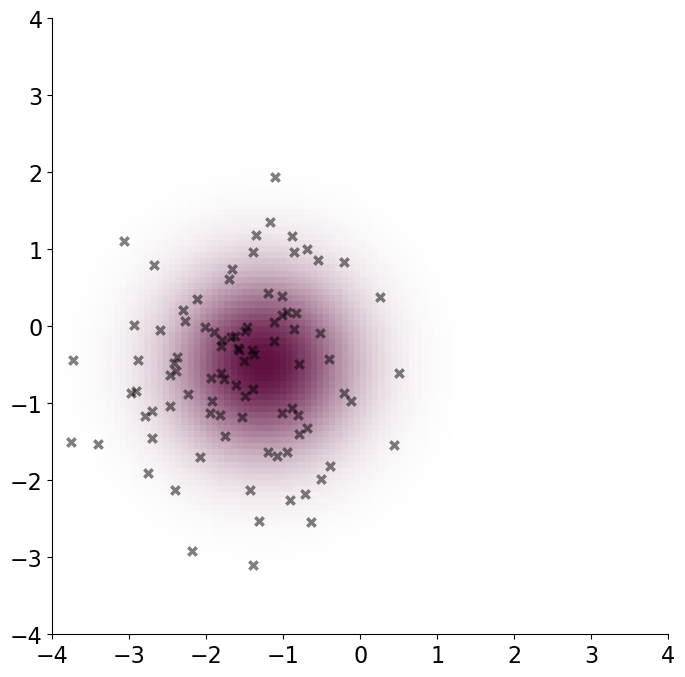

In [ ]:
# We set up the bounds and find the max value
xlim = ylim = (-4, 4)

from scipy.optimize import minimize
minimize_result = minimize(lambda x: - Q_of_rho(result_0.states[-1], x[0], x[1]), [0, 0])
max_bound = - 1.05 * minimize_result.fun

# Now we can generate hit-miss samples
n_samples = 1000
x_sample = np.random.uniform(*xlim, n_samples)
y_sample = np.random.uniform(*ylim, n_samples)
p_sample = np.random.uniform(0, max_bound, n_samples)

# Generate true vals of x and y
p_calculated = Q_of_rho(result_0.states[-1], x_sample, y_sample)

# Mask from the hit-n-miss
mask = p_sample < p_calculated


# Q func 
xvec = yvec = np.linspace(*xlim, 100)
X, Y = np.meshgrid(xvec, yvec)
q_0 = qfunc(ptrace(result_0.states[-1], 1))
q_0_own = Q_of_rho(result_0.states[-1], X.flatten(), Y.flatten()).reshape(X.shape)

plt.imshow(q_0, extent = [xvec[0], xvec[-1], yvec[0], yvec[-1]], origin = "lower", cmap = cmap_0)


plt.scatter(x_sample[mask], y_sample[mask], marker = "x", color = "black", alpha = 0.5)

np.sum(mask)